# Attend Infer Repeat

In this tutorial we will implement the model and inference strategy described in "Attend, Infer, Repeat:
Fast Scene Understanding with Generative Models" (AIR) [1] and apply it to the multi-mnist dataset.

A [standalone implementation](https://github.com/uber/pyro/tree/dev/examples/air) is also available.

In [1]:
%pylab inline
import os
from collections import namedtuple
from observations import multi_mnist
import pyro
import pyro.optim as optim
from pyro.infer import SVI
import pyro.distributions as dist
from pyro.util import ng_zeros, ng_ones
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.functional import relu, sigmoid, softplus, grid_sample, affine_grid
import numpy as np
smoke_test = ('CI' in os.environ)

## Introduction

The model described in [1] is a generative model of scenes. In this tutorial we will use it to model images from a dataset that is similar to the multi-mnist dataset in [1]. Here are some data points from this data set:

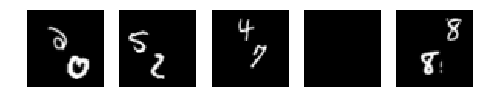

In [2]:
inpath = '../../examples/air/data'
(X_np, _), _ = multi_mnist(inpath, max_digits=2, canvas_size=50, seed=42)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = Variable(torch.from_numpy(X_np))
def show_images(imgs):
    figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        subplot(1, len(imgs), i + 1)
        axis('off')
        imshow(img.data.numpy(), cmap='gray')
show_images(mnist[9:14])

To get an idea where we're heading, we first give a brief overview of the model and the approach we'll take to inference. We'll follow the naming conventions used in [1] as closely as possible.

AIR decomposes the process of generating an image into discrete steps, each of which generates only part of the image. More specifically, at each step the model will generate a small image (`y_att`) by passing a latent "code" variable (`z_what`) through a neural network. We'll refer to these small images as "objects". In the case of AIR applied to the multi-mnist dataset we expect each of these objects to represent a single digit. The model also includes uncertainty about the location and size of each object. We'll describe an object's location and size as its "pose" (`z_where`). To produce the final image, each object will first be located within a larger image (`y`) using the pose infomation `z_where`. Finally, the `y`s from all time steps will be combined additively to produce the final image `x`.

Here's a picture (reproduced from [1]) that shows two steps of this process:

Inference is performed in this model using [amortized stochastic variational inference](svi_part_i.html) (SVI). The parameters of the neural network are also optimized during inference. Performing inference in such rich models is always difficult, but the presence of discrete choices (the number of steps in this case) makes inference in this model particularly tricky. For this reason the authors use a technique called data dependent baselines to achieve good performance. This technique can be implemented in Pyro, and we'll see how later in the tutorial.

## Model

### Generating a single object

Let's look at the model more closely. At the core of the model is the generative process for a single object. Recall that:

* At each step a single object is generated.
* Each object is generated by passing its latent code through a neural network.
* We maintain uncertainty about the latent code used to generate each object, as well as its pose.

This can be expressed in Pyro like so:

In [3]:
# Create the neural network. This takes a latent code, z_what, to pixel intensities.
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(50, 200)
        self.l2 = nn.Linear(200, 400)

    def forward(self, z_what):
        h = relu(self.l1(z_what))
        return sigmoid(self.l2(h))

decode = Decoder()

z_where_prior_mu = Variable(torch.Tensor([3, 0, 0]))
z_where_prior_sigma = Variable(torch.Tensor([0.1, 1, 1]))
z_what_prior_mu = ng_zeros(50)
z_what_prior_sigma = ng_ones(50)

def prior_step_sketch(t):
    # Sample object pose. This is a 3-dimensional vector representing x,y position and size.
    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.normal,
                          z_where_prior_mu.expand(1, -1),
                          z_where_prior_sigma.expand(1, -1),
                          extra_event_dims=1)

    # Sample object code. This is a 50-dimensional vector.
    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.normal,
                         z_what_prior_mu.expand(1, -1),
                         z_what_prior_sigma.expand(1, -1),
                         extra_event_dims=1)
    
    # Map code to pixel space using the neural network.
    y_att = decode(z_what)

    # Position/scale object within larger image.
    y = object_to_image(z_where, y_att)

    return y

Hopefully the use of `pyro.sample` and PyTorch networks within a model seem familiar at this point. If not you might want to review the [VAE tutorial](vae.html). One thing to note is that we include the current step `t` in the name passed to `pyro.sample` to ensure that names are unique across steps.

The `object_to_image` function is specific to this model and warrants further attention. Recall that the neural network (`decode` here) will output a small image, and that we would like to add this to the output image after performing any translation and scaling required to achieve the pose (location and size) described by `z_where`. It's not clear how to do this, and in particular it's not obvious that this can be implemented in a way that preserves the differentiability of our model, which we require in order to perform [SVI](svi_part_i.html). However, it turns out we can do this this using a spatial transformer network (STN) [2].

Happily for us, PyTorch makes it easy to implement a STN using its [grid_sample](http://pytorch.org/docs/master/nn.html#grid-sample) and [affine_grid](http://pytorch.org/docs/master/nn.html#affine-grid) functions. `object_to_image` is a simple function that calls these, doing a little extra work to massage `z_where` into the expected format.

In [4]:
def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = z_where.size(0)
    expansion_indices = Variable(torch.LongTensor([1, 0, 2, 0, 1, 3]))
    out = torch.cat((ng_zeros([1, 1]).expand(n, 1), z_where), 1)
    return torch.index_select(out, 1, expansion_indices).view(n, 2, 3)

def object_to_image(z_where, obj):
    n = obj.size(0)
    theta = expand_z_where(z_where)
    grid = affine_grid(theta, torch.Size((n, 1, 50, 50)))
    out = grid_sample(obj.view(n, 1, 20, 20), grid)
    return out.view(n, 50, 50)

A discussion of the details of the STN is beyond the scope of this tutorial. For our purposes however, it suffices to keep in mind that `object_to_image` takes the small image generated by the neural network and places it within a larger image with the desired pose.

Let's visualize the results of calling `prior_step_sketch` a few times to clarify this:

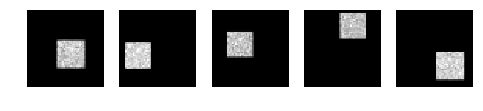

In [5]:
pyro.set_rng_seed(0)
samples = [prior_step_sketch(0)[0] for _ in range(5)]
show_images(samples)

### Generating an entire image

Having completed the implementation of a single step, we next consider how we can use this to generate an entire image. Recall that we would like to maintain uncertainty over the number of steps used to generate each data point. One choice we could make for the prior over the number of steps is the geometric distribution, which can be expressed as follows:

In [6]:
pyro.set_rng_seed(0)
def geom(num_trials=0):
    p = Variable(torch.Tensor([0.5]))
    x = pyro.sample('x{}'.format(num_trials), dist.bernoulli, p)
    if x.data[0] == 1:
        return num_trials
    else:
        return geom(num_trials + 1)

# Generate some samples.
for _ in range(5):
    print('sampled {}'.format(geom()))

sampled 8
sampled 2
sampled 0
sampled 0
sampled 1


This is a direct translation of the definition of the geometric distribution as the number of failures before a success in a series of Bernoulli trials. Here we express this as a recursive function that passes around a counter representing the number of trials made, `num_trials`. This function samples from the Bernoulli and returns `num_trials` if `x == 1` (which represents success), otherwise it makes a recursive call, incrementing the counter.

The use of a geometric prior is appealing because it does not bound the number of steps the model can use a priori. It's also convenient, because by extending `geometric` to generate an object before each recursive call, we turn this from a geometric distribution over counts to a distribution over images with a geometrically distributed number of steps.

In [7]:
def geom_prior(x, step=0):
    p = Variable(torch.Tensor([0.5]))
    i = pyro.sample('i{}'.format(step), dist.bernoulli, p)
    if i.data[0] == 1:
        return x
    else: 
        x = x + prior_step_sketch(step)
        return geom_prior(x, step + 1)

Let's visualize some samples from this distribution:

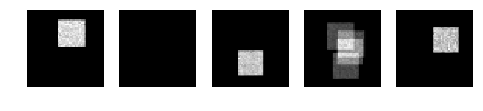

In [8]:
pyro.set_rng_seed(13)
x_empty = ng_zeros(1, 50, 50)
samples = [geom_prior(x_empty)[0] for _ in range(5)]
show_images(samples)

#### Aside: Vectorized mini-batches

In our final implementation we would like to generate a mini batch of samples in parallel for efficiency. While Pyro supports vectorized mini batches with `iarange`, it currently requires that each `sample` statement within `iarange` makes a choice for all samples in the mini batch. Another way to say this is that each sample in the mini batch will encounter the same set of `sample` statements. This is problematic for us, because as we've just seen, samples can make differing numbers of choices under our model.

One way around this is to have all samples take the same number of steps, but to nullify (so far as is possible) the effect of the superfuous random choices made after the sample is conceptually "complete". We'll say that a sample is "complete" once a zero is sampled from the Bernoulli random choice, and prior to that we'll say that a sample is "active".

The first part of this is straight forward. Following [1] we choose to take a fixed number of steps for each sample. (By doing so we no longer specify a geometric distribution over the number of steps, since the number of steps is now bounded. It would be interesting to explore the alternative of having each sample in the batch take steps until a successful Bernoulli trial has occured in each, as this would retain the geometric prior.)

To address the second part we will take the following steps:

1. Only add objects to the output while a sample is active.
2. Use the `log_pdf_mask` argument of `pyro.sample` to set the log probability of random choices made by complete samples to zero. (Since the [SVI loss](svi_part_iii.html) is a weighted sum of log probabilities, setting a choice's log probability to zero effectively removes its contribution to the loss.)

(Looking ahead, we'll need to take similar measures when we implement the guide and add baselines later in this tutorial.)

Of course, one thing we can't undo is the work done in performing unncessary sampling. Nevertheless, even though this approach performs redundant computation, the gains from using mini batches are so large that this is still a win overall.

Here's an updated model step function that implements these ideas. In summary, the changes from `prior_step_sketch` are:

1. We've added a new parameter `n` that specifies the size of the mini batch.
2. We now conditionally add the object to the output image based on a value sampled from a Bernoulli distribution.
3. We use `log_pdf_mask` to zero out the log probability of random choices made by complete samples.

In [9]:
def prior_step(n, t, prev_x, prev_z_pres):

    # Sample variable indicating whether to add this object to the output.

    # We multiply the success probability of 0.5 by the value sampled for this
    # choice in the previous step. By doing so we add objects to the output until
    # the first 0 is sampled, after which we add no further objects.
    z_pres = pyro.sample('z_pres_{}'.format(t), 
                         dist.bernoulli, 
                         0.5 * prev_z_pres,
                         extra_event_dims=1)

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.normal,
                          z_where_prior_mu.expand(n, -1),
                          z_where_prior_sigma.expand(n, -1),
                          log_pdf_mask=z_pres.squeeze(-1),
                          extra_event_dims=1)

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.normal,
                         z_what_prior_mu.expand(n, -1),
                         z_what_prior_sigma.expand(n, -1),
                         log_pdf_mask=z_pres.squeeze(-1),
                         extra_event_dims=1)

    y_att = decode(z_what)
    y = object_to_image(z_where, y_att)

    # Combine the image generated at this step with the image so far.
    x = prev_x + y * z_pres.view(-1, 1, 1)

    return x, z_pres

By iterating this step function we can produce an entire image, composed of multiple objects. Since each image in the multi-mnist dataset contains zero, one or two digits we will allow the model to use up to (and including) three steps. In this way we ensure that inference has to avoid using one or more steps in order to correctly count the number of objects in the input.

In [10]:
def prior(n):
    x = ng_zeros(n, 50, 50)
    z_pres = ng_ones(n, 1)
    for t in range(3):
        x, z_pres = prior_step(n, t, x, z_pres)
    return x

We have now fully specified the prior for our model. Let's visualize some samples to get a feel for this distribution:

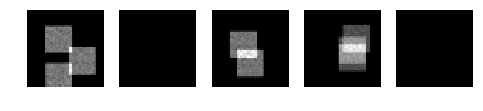

In [11]:
pyro.set_rng_seed(87678)
show_images(prior(5))

#### Specifying the likelihood

The last thing we need in order to complete the specification of the model is a likelihood function. Following [1] we will use a Gaussian likelihood with a fixed standard deviation of 0.3. This is straight forward to implement with `pyro.sample` using the `obs` argument.

When we later come to perform inference we will find it convenient to package the prior and likelihood into a single function. This is also a convenient place to introduce `iarange`, which we use to implement data subsampling, and to register the networks we would like to optimize with `pyro.module`.

In [12]:
def model(data):
    # Register network for optimization.
    pyro.module("decode", decode)
    with pyro.iarange('data', data.size(0)) as indices:
        batch = data[indices]
        x = prior(batch.size(0)).view(-1, 50 * 50)
        sd = (0.3 * ng_ones(1)).expand_as(x)
        pyro.sample('obs', dist.normal, x, sd, obs=batch, extra_event_dims=1)

## Guide

Following [1] we will perform [amortized stochastic variational inference](svi_part_i.html) in this model. Pyro provides general purpose machinery that implements most of this inference strategy, but as we have seen in earlier tutorials we are required to provide a model specific guide. What we call a guide in Pyro is exactly the entity called the "inference network" in the paper.

We will structure the guide around a recurrent network to allow the guide to capture (some of) the dependencies we expect to be present in the true posterior. At each step the recurrent network will generate the parameters for the choices made within the step. The values sampled will be fed back into the recurrent network so that this information can be used when computing the parameters for the next step. The guide for the [Deep Markov Model](dmm.html) shares a similar structure.

As in the model, the core of the guide is the logic for a single step. Here's a sketch of an implementation of this:

In [13]:
def guide_step_basic(t, data, prev):

    # The RNN takes the images and choices from the previous step as input.
    rnn_input = torch.cat((data, prev.z_where, prev.z_what, prev.z_pres), 1)
    h, c = rnn(rnn_input, (prev.h, prev.c))

    # Compute parameters for all choices made this step, by passing
    # the RNN hidden start through another neural network.
    z_pres_p, z_where_mu, z_where_sigma, z_what_mu, z_what_sigma = predict_basic(h)

    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.bernoulli, 
                         z_pres_p * prev.z_pres)

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.normal, 
                          z_where_mu, 
                          z_where_sigma)

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.normal, 
                         z_what_mu, 
                         z_what_sigma)

    return # values for next step

This would be a reasonable guide to use with this model, but the paper describes a crucial improvement we can make to the code above. Recall that the guide will output information about an object's pose and its latent code at each step. The improvement we can make is based on the observation that once we have inferred the pose of an object, we can do a better job of inferring its latent code if we use the pose information to crop the object from the input image, and pass the result (which we'll call a "window") through an additional network in order to compute the parameters of the latent code. We'll call this additional network the "encoder" below.

Here's how we can implement this improved guide, and a fleshed out implementation of the networks involved:

In [14]:
rnn = nn.LSTMCell(2554, 256)

# Takes pixel intensities of the attention window to parameters (mean,
# standard deviation) of the distribution over the latent code,
# z_what.
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(400, 200)
        self.l2 = nn.Linear(200, 100)

    def forward(self, data):
        h = relu(self.l1(data))
        a = self.l2(h)
        return a[:, 0:50], softplus(a[:, 50:])

encode = Encoder()

# Takes the guide RNN hidden state to parameters of
# the guide distributions over z_where and z_pres.
class Predict(nn.Module):
    def __init__(self, ):
        super(Predict, self).__init__()
        self.l = nn.Linear(256, 7)

    def forward(self, h):
        a = self.l(h)
        z_pres_p = sigmoid(a[:, 0:1]) # Squish to [0,1]
        z_where_mu = a[:, 1:4]
        z_where_sigma = softplus(a[:, 4:]) # Squish to >0
        return z_pres_p, z_where_mu, z_where_sigma

predict = Predict()

def guide_step_improved(t, data, prev):

    rnn_input = torch.cat((data, prev.z_where, prev.z_what, prev.z_pres), 1)
    h, c = rnn(rnn_input, (prev.h, prev.c))
    z_pres_p, z_where_mu, z_where_sigma = predict(h)

    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.bernoulli, 
                         z_pres_p * prev.z_pres,
                         extra_event_dims=1)

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.normal, 
                          z_where_mu, 
                          z_where_sigma,
                          extra_event_dims=1)

    # New. Crop a small window from the input.
    x_att = image_to_object(z_where, data)

    # Compute the parameter of the distribution over z_what
    # by passing the window through the encoder network.
    z_what_mu, z_what_sigma = encode(x_att)

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.normal, 
                         z_what_mu, 
                         z_what_sigma,
                         extra_event_dims=1)

    return # values for next step

Since we would like to maintain differentiability of the guide we again use a STN to perform the required "cropping". The `image_to_object` function performs the opposite transform to the object_to_image function used in the guide. That is, the former takes a small image and places it on a larger image, and the latter crops a small image from a larger image.

In [15]:
def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = z_where.size(0)
    out = torch.cat((ng_ones([1, 1]).type_as(z_where).expand(n, 1), -z_where[:, 1:]), 1)
    out = out / z_where[:, 0:1]
    return out

def image_to_object(z_where, image):
    n = image.size(0)
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid(theta_inv, torch.Size((n, 1, 20, 20)))
    out = grid_sample(image.view(n, 1, 50, 50), grid)
    return out.view(n, -1)

### Another perspective

So far we've considered the model and the guide in isolation, but we gain an interesting perspective if we zoom out and look at the model and guide computation as a whole. Doing so, we see that at each step AIR includes a sub-computation that has the same structure as a [Variational Auto-encoder](vae.html) (VAE).

To see this, notice that the guide passes the window through a neural network (the encoder) to generate the parameters of the distribution over a latent code, and the model passes samples from this latent code distribution through another neural network (the decoder) to generate an output window. This structure is highlighted in the following figure, reproduced from [1]:

From this perspective AIR is seen as a sequential variant of the VAE. The act of cropping a small window from the input image serves to restrict the attention of a VAE to a small region of the input image at each step; hence "Attend, Infer, Repeat".

## Inference

As we mentioned in the introduction, successfully performing inference in this model is a challenge. In particular, the presence of discrete choices in the model makes inference trickier than in a model in which all choices can be reparameterized. The underlying problem we face is that the gradient estimates we use in the optimization performed by variational inference have much higher variance in the presence of [non-reparameterizable choices](svi_part_iii.html#Tricky-Case:-Non-reparameterizable-Random-Variables).

To bring this variance under control, the paper applies a technique called "data dependent baselines" (AKA "neural baselines") to the discrete choices in the model.

### Data dependent baselines

Happily for us, Pyro includes support for data dependent baselines. If you are not already familiar with this idea, you might want to read [our introduction](svi_part_iii.html#Baselines-in-Pyro) before continuing. As model authors we only have to implement the neural network, pass it our data as input, and feed its output to `pyro.sample`. Pyro's inference back-end will ensure that the baseline is included in the gradient estimator used for inference, and that the network parameters are updated appropriately.

Let's see how we can add data dependent baselines to our AIR implementation. We need a neural network that can output a (scalar) baseline value at each discrete choice in the guide, having received a multi-mnist image and the values sampled by the guide so far as input. Notice that this is very similar to the structure of the guide network, and indeed we will again use a recurrent network.

To implement this we will first write a short helper function that implements a single step of the RNN we've just described:

In [16]:
bl_rnn = nn.LSTMCell(2554, 256)
bl_predict = nn.Linear(256, 1)

# Use an RNN to compute the baseline value. This network takes the
# input images and the values samples so far as input.
def baseline_step(x, prev):
    rnn_input = torch.cat((x,
                           prev.z_where.detach(),
                           prev.z_what.detach(),
                           prev.z_pres.detach()), 1)
    bl_h, bl_c = bl_rnn(rnn_input, (prev.bl_h, prev.bl_c))
    bl_value = bl_predict(bl_h) * prev.z_pres
    return bl_value, bl_h, bl_c

There are two important details to highlight here:

First, we `detach` values sampled by the guide before passing them to the baseline network. This is important as the baseline network and the guide network are entirely separate networks optimized with different objectives. Without this, gradients would flow from the baseline network into the guide network. When using data dependent baselines we must do this whenever we feed values sampled by the guide into the baselines network. (If we don't we'll trigger a PyTorch run-time error.)

Second, we multiply the output of the baseline network by the value of `z_pres` from the previous step. This relieves the baseline network from the burdon of having to output accurate predictions for completed samples. (The outputs for completed samples will be multiplied by zero, so the derivative of the [baseline loss](svi_part_iii.html#Neural-Baselines) for these outputs will be zero.) It's OK to do this because in effect we've already removed random choices for completed samples from the inference objective, so there's no need to apply any variance reduction to them.

We now have everything we need to complete the implementation of the guide. Our final `guide_step` function will be very similar to `guide_step_improved` introduced above. The only changes are:

1. We now call the `baseline_step` helper and pass the baseline value it returns to `pyro.sample`.
2. We've added `log_pdf_mask` arguments to `pyro.sample` calls. These serve exactly the same purpose as the masks added to the model. (See the earlier discussion for the motivation behind this change.)

We'll also write a `guide` function that will iterate `guide_step` in order to provide a guide for the whole model.

In [17]:
GuideState = namedtuple('GuideState', ['h', 'c', 'bl_h', 'bl_c', 'z_pres', 'z_where', 'z_what'])
def initial_guide_state(n):
    return GuideState(h=ng_zeros(n, 256),
                      c=ng_zeros(n, 256),
                      bl_h=ng_zeros(n, 256),
                      bl_c=ng_zeros(n, 256),
                      z_pres=ng_ones(n, 1),
                      z_where=ng_zeros(n, 3),
                      z_what=ng_zeros(n, 50))

def guide_step(t, data, prev):

    rnn_input = torch.cat((data, prev.z_where, prev.z_what, prev.z_pres), 1)
    h, c = rnn(rnn_input, (prev.h, prev.c))
    z_pres_p, z_where_mu, z_where_sigma = predict(h)

    # Here we compute the baseline value, and pass it to sample.
    baseline_value, bl_h, bl_c = baseline_step(data, prev)
    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.bernoulli,
                         z_pres_p * prev.z_pres,
                         baseline=dict(baseline_value=baseline_value.squeeze(-1)),
                         extra_event_dims=1)

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.normal, 
                          z_where_mu, 
                          z_where_sigma,
                          extra_event_dims=1)
    
    x_att = image_to_object(z_where, data)

    z_what_mu, z_what_sigma = encode(x_att)

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.normal, 
                         z_what_mu, 
                         z_what_sigma,
                         extra_event_dims=1)

    return GuideState(h=h, c=c, bl_h=bl_h, bl_c=bl_c, z_pres=z_pres, z_where=z_where, z_what=z_what)

def guide(data):
    # Register networks for optimization.
    pyro.module('rnn', rnn),
    pyro.module('predict', predict),
    pyro.module('encode', encode),
    pyro.module('bl_rnn', bl_rnn)
    pyro.module('bl_predict', bl_predict)

    with pyro.iarange('data', data.size(0), subsample_size=64) as indices:
        batch = data[indices]
        state = initial_guide_state(batch.size(0))
        steps = []
        for t in range(3):
            state = guide_step(t, batch, state)
            steps.append(state)
        return steps

### Putting it all together

We have now completed the implementation of the model and the guide. As we have seen in earlier tutorials, we need write only a few more lines of code to begin performing inference:

In [18]:
data = mnist.view(-1, 50 * 50)

svi = SVI(model,
          guide,
          optim.Adam({'lr': 1e-4}),
          loss='ELBO',
          trace_graph=True)

for i in range(5):
    loss = svi.step(data)
    print('i={}, elbo={:.2f}'.format(i, loss / data.size(0)))

One key detail here is that we pass the `trace_graph=True` option to `SVI`. This indicates that we wish to use the gradient estimator that supports data dependent baselines. This estimator also [reduces the variance](svi_part_iii.html#Reducing-Variance-via-Dependency-Structure) of gradient estimates by making use of independence information included in the model. Something similar is implicity used in [1], and is necessary in order to achieve good results on this model.

## Results

To sanity check our implementation we ran inference using our [standalone implementation](https://github.com/uber/pyro/tree/dev/examples/air) and compared its performance against some of the results reported in [1].

Here we show progress made on the ELBO and training set count accuracy during optimization:

Count accuracy reached around 98.7%, which is in the same ballpark as the count accuracy reported in [1]. The value reached on the ELBO differs a little from that reported in [1], which may be due to small differences in the priors used.

In the next figure the top row shows ten data points from the test set. The bottom row is a visualization of a single sample from the guide for each of these inputs, that shows the values sampled for `z_pres` and `z_where`. Following [1], the first, second and third steps are displayed using red, green and blue borders respectively. (No blue borders are shown as the guide did not use three steps for any of these samples.) It also shows reconstructions of the input obtained by passing the latent variables sampled from the guide back through the model to generate an output image.

These results were collected using the following parameters:

```
python main.py -n 200000 -blr 0.1 --z-pres-prior 0.01 --scale-prior-sd 0.2 --predict-net 200 --bl-predict-net 200 --decoder-output-use-sigmoid --decoder-output-bias -2 --seed 287710
```

We used Pyro commit `c0b38ad` with PyTorch `0.2.0.post4`. Inference ran for approximately 4 hours on an NVIDIA K80 GPU. (Note that even though we set the random seed, this isn't sufficient to make inference deterministic when using CUDA.)

## In practice

We found it important to pay attention to the following details in order to achieve good results with AIR.

* Inference is unlikely to recover correct object counts unless a small prior success probability for `z_pres` is used. In [1] this [probability was annealed](http://akosiorek.github.io/ml/2017/09/03/implementing-air.html) from a value close to one to `1e-5` (or less) during optimization, though we found that a fixed value of around `0.01` worked well with our implementation.
* We initialize the decoder network to generate mostly empty objects initially. (Using the `--decoder-output-bias` argument.) This encourages the guide to explore the use of objects to explain the input early in optimization. Without this each object is a mid-gray square which is heavily penalized by the likelihood, prompting the guide to turn most steps off.
* It is reported to be useful in practice to use a different learning rate for the baseline network. This is straight forward to implement in Pyro by tagging modules associated with the baseline network and passing multiple learning rates to the optimizer. (See the section on [optimizers](svi_part_i.html#Optimizers) in part I of the SVI tutorial for more detail.) In [1] a learning rate of `1e-4` was used for the guide network, and a learning rate of `1e-3` was used for the baseline network. We found it necessary to use a larger learning rate for the baseline network in order to make progress on count accuracy at a similar rate to [1]. This difference is likely caused by Pyro setting up a [slightly different baseline loss](https://github.com/uber/pyro/issues/555).


## References

[1] `Attend, Infer, Repeat: Fast Scene Understanding with Generative Models`
<br />&nbsp;&nbsp;&nbsp;&nbsp;
S. M. Ali Eslami and Nicolas Heess and Theophane Weber and Yuval Tassa and Koray Kavukcuoglu and Geoffrey E. Hinton

[2] `Spatial Transformer Networks`
<br />&nbsp;&nbsp;&nbsp;&nbsp;
Max Jaderberg and Karen Simonyan and Andrew Zisserman